In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packag

In [2]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

## Load the data

In [3]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer_new")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]
out_image_path = f"image/germband_morphofield/morpho_acceleration"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [4]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_germband_v4_acceleration.h5ad")

germ_pc = st.tdr.read_model(f"morpho_models/germband_morphometrics_pc_model.vtk")
germ_mesh = st.tdr.read_model(f"morpho_models/germband_morphometrics_mesh_model.vtk")
trajectory_model = st.tdr.read_model(f"morpho_models/germband_morphofield_trajectory_model.vtk")
germ_adata

AnnData object with n_obs × n_vars = 12585 × 8120
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## GLM DEGs

In [5]:
germ_adata.X= germ_adata.layers["X_counts"].copy()
sc.pp.normalize_total(germ_adata)
sc.pp.log1p(germ_adata)

In [6]:
GNs = [
    "Rab30", "rhea", "Mtl", "srp", "raw", "peb", "ecd", "EcR", "Egfr", "ush", "Rac2", "Rac1", "tup", "yrt", "POSH", "sr", "InR", "ena",
    "Ndg","Ret","scb","mys","Zasp52","muskelin","Pten","Itgbn","Fit2","Fit1","m","mew","Ilk","tyn","Sema2b","if"
]
for gn in GNs:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    out_image_genes = os.path.join(out_image_path, "migration_related_genes")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)
    
    pc_index=germ_pc.point_data["obs_index"].tolist()
    exp = germ_adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=germ_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=germ_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_genes, f"{sample_id}_germband_morpho_acceleration_model_{_gn}.pdf")
    )


KeyboardInterrupt



In [6]:
st.tl.glm_degs(
    adata=germ_adata,
    fullModelFormulaStr=f'~cr(morpho_acceleration, df=3)',
    key_added="glm_degs",
    qval_threshold=0.01,
    llf_threshold=-100,
)
print(germ_adata.uns["glm_degs"]["glm_result"])

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [1127.2741s]
          status family  log-likelihood          pval          qval
nur           ok    NB2    -3032.886475  0.000000e+00  0.000000e+00
CG13159       ok    NB2    -2724.717041  0.000000e+00  0.000000e+00
pip           ok    NB2    -1099.084595  0.000000e+00  0.000000e+00
Ance          ok    NB2    -3218.701904  0.000000e+00  2.242078e-44
Cys           ok    NB2   -10076.283203  2.802597e-45  5.053082e-42
...          ...    ...             ...           ...           ...
Bub3          ok    NB2    -1341.125000  3.061676e-04  7.968209e-03
insc 

In [9]:
glm_data = germ_adata.uns["glm_degs"]["glm_result"]
glm_data= glm_data.loc[glm_data["log-likelihood"] >= -2000, :]
# glm_data= glm_data.loc[glm_data["log-likelihood"] <= -500, :]
# glm_data= glm_data.loc[glm_data["pval"] >= 1e-10, :]
glm_data= glm_data.loc[glm_data["pval"] <= 1e-5, :]
print(glm_data)

             status family  log-likelihood          pval          qval
pip              ok    NB2    -1099.084595  0.000000e+00  0.000000e+00
Abd-B            ok    NB2     -758.048340  1.760276e-39  2.382240e-36
CG34190          ok    NB2     -681.737549  1.196937e-35  1.079903e-32
Papss            ok    NB2     -672.873108  2.431555e-33  1.974422e-30
Gmap             ok    NB2    -1748.306274  1.720348e-26  1.074556e-23
...             ...    ...             ...           ...           ...
E(spl)m6-BFM     ok    NB2     -712.511292  8.120139e-06  4.226636e-04
mRpL27           ok    NB2    -1191.151611  8.527982e-06  4.373499e-04
Antp             ok    NB2     -912.598938  8.563871e-06  4.373499e-04
CG8353           ok    NB2    -1302.346924  8.702624e-06  4.416582e-04
clu              ok    NB2    -1470.830444  9.826259e-06  4.865196e-04

[86 rows x 5 columns]


In [10]:
GNs = [
    "Rab30", "rhea", "Mtl", "srp", "raw", "peb", "ecd", "EcR", "Egfr", "ush", "Rac2", "Rac1", "tup", "yrt", "POSH", "sr", "InR", "ena",
    "Ndg","Ret","scb","mys","Zasp52","muskelin","Pten","Itgbn","Fit2","Fit1","m","mew","Ilk","tyn","Sema2b","if", "top", "flb", "Egfr", "inr", "hnt",
]
new_GNs = []
for i in GNs:
    if i in germ_adata.uns["glm_degs"]["glm_result"].index:
        new_GNs.append(i)
new_GNs

['peb', 'ena']

In [11]:
print(germ_adata.uns["glm_degs"]["glm_result"].loc[new_GNs, :])

    status family  log-likelihood      pval      qval
peb     ok    NB2    -1302.260254  0.000002  0.000143
ena     ok    NB2    -1877.520996  0.000077  0.002655


In [10]:
st.pl.glm_fit(
    adata=germ_adata,
    genes=list(glm_data.index),
    ncols=5,
    feature_x="morpho_acceleration",
    feature_y="expression",
    glm_key="glm_degs",
    save_show_or_return="all",
    color_key="morpho_acceleration",
    color_key_cmap="vlag",
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_fit"), prefix=None, ext="pdf", dpi=300)
)

Saving figure to image/germband_morphofield/morpho_acceleration/E7_8h_germband_morpho_acceleration_glm_degs_fit.pdf...
Done


In [12]:
glm_data = germ_adata.uns["glm_degs"]["glm_result"]
selected_genes = ["Gmap", "otp","CG32425","DNaseII","SpdS","Pdp1","CG45116","CG8036","CG2930","CG33099",
                  "CG42565","cad","CG32267","GstE5","CG8468","CG44286","peb","Glo1","CG43051","mRpL27","clu",]
glm_data = glm_data.loc[selected_genes, :]
glm_data.to_csv(os.path.join(out_image_path, f"Germband_acceleration_selected_glm_degs.csv"), sep="\t")
glm_data

,status,family,log-likelihood,pval,qval
Gmap,ok,NB2,-1748.306274,1.720348e-26,1.074556e-23
otp,ok,NB2,-371.687927,1.078223e-15,3.287929e-13
CG32425,ok,NB2,-1289.530151,2.322101e-14,6.285153e-12
DNaseII,ok,NB2,-1012.456604,6.221524e-14,1.530872e-11
SpdS,ok,NB2,-1682.759888,2.165884e-13,5.172640e-11
Pdp1,ok,NB2,-1173.230347,3.570789e-12,7.630212e-10
CG45116,ok,NB2,-561.447144,6.564757e-10,9.691968e-08
CG8036,ok,NB2,-1709.352173,1.872589e-08,1.974730e-06
CG2930,ok,NB2,-292.684692,1.721330e-08,1.839106e-06
CG33099,ok,NB2,-547.889465,7.069992e-08,6.753921e-06


Saving figure to image/germband_morphofield/morpho_acceleration/E7_8h_germband_morpho_acceleration_selected_glm_degs_fit.pdf...
Done


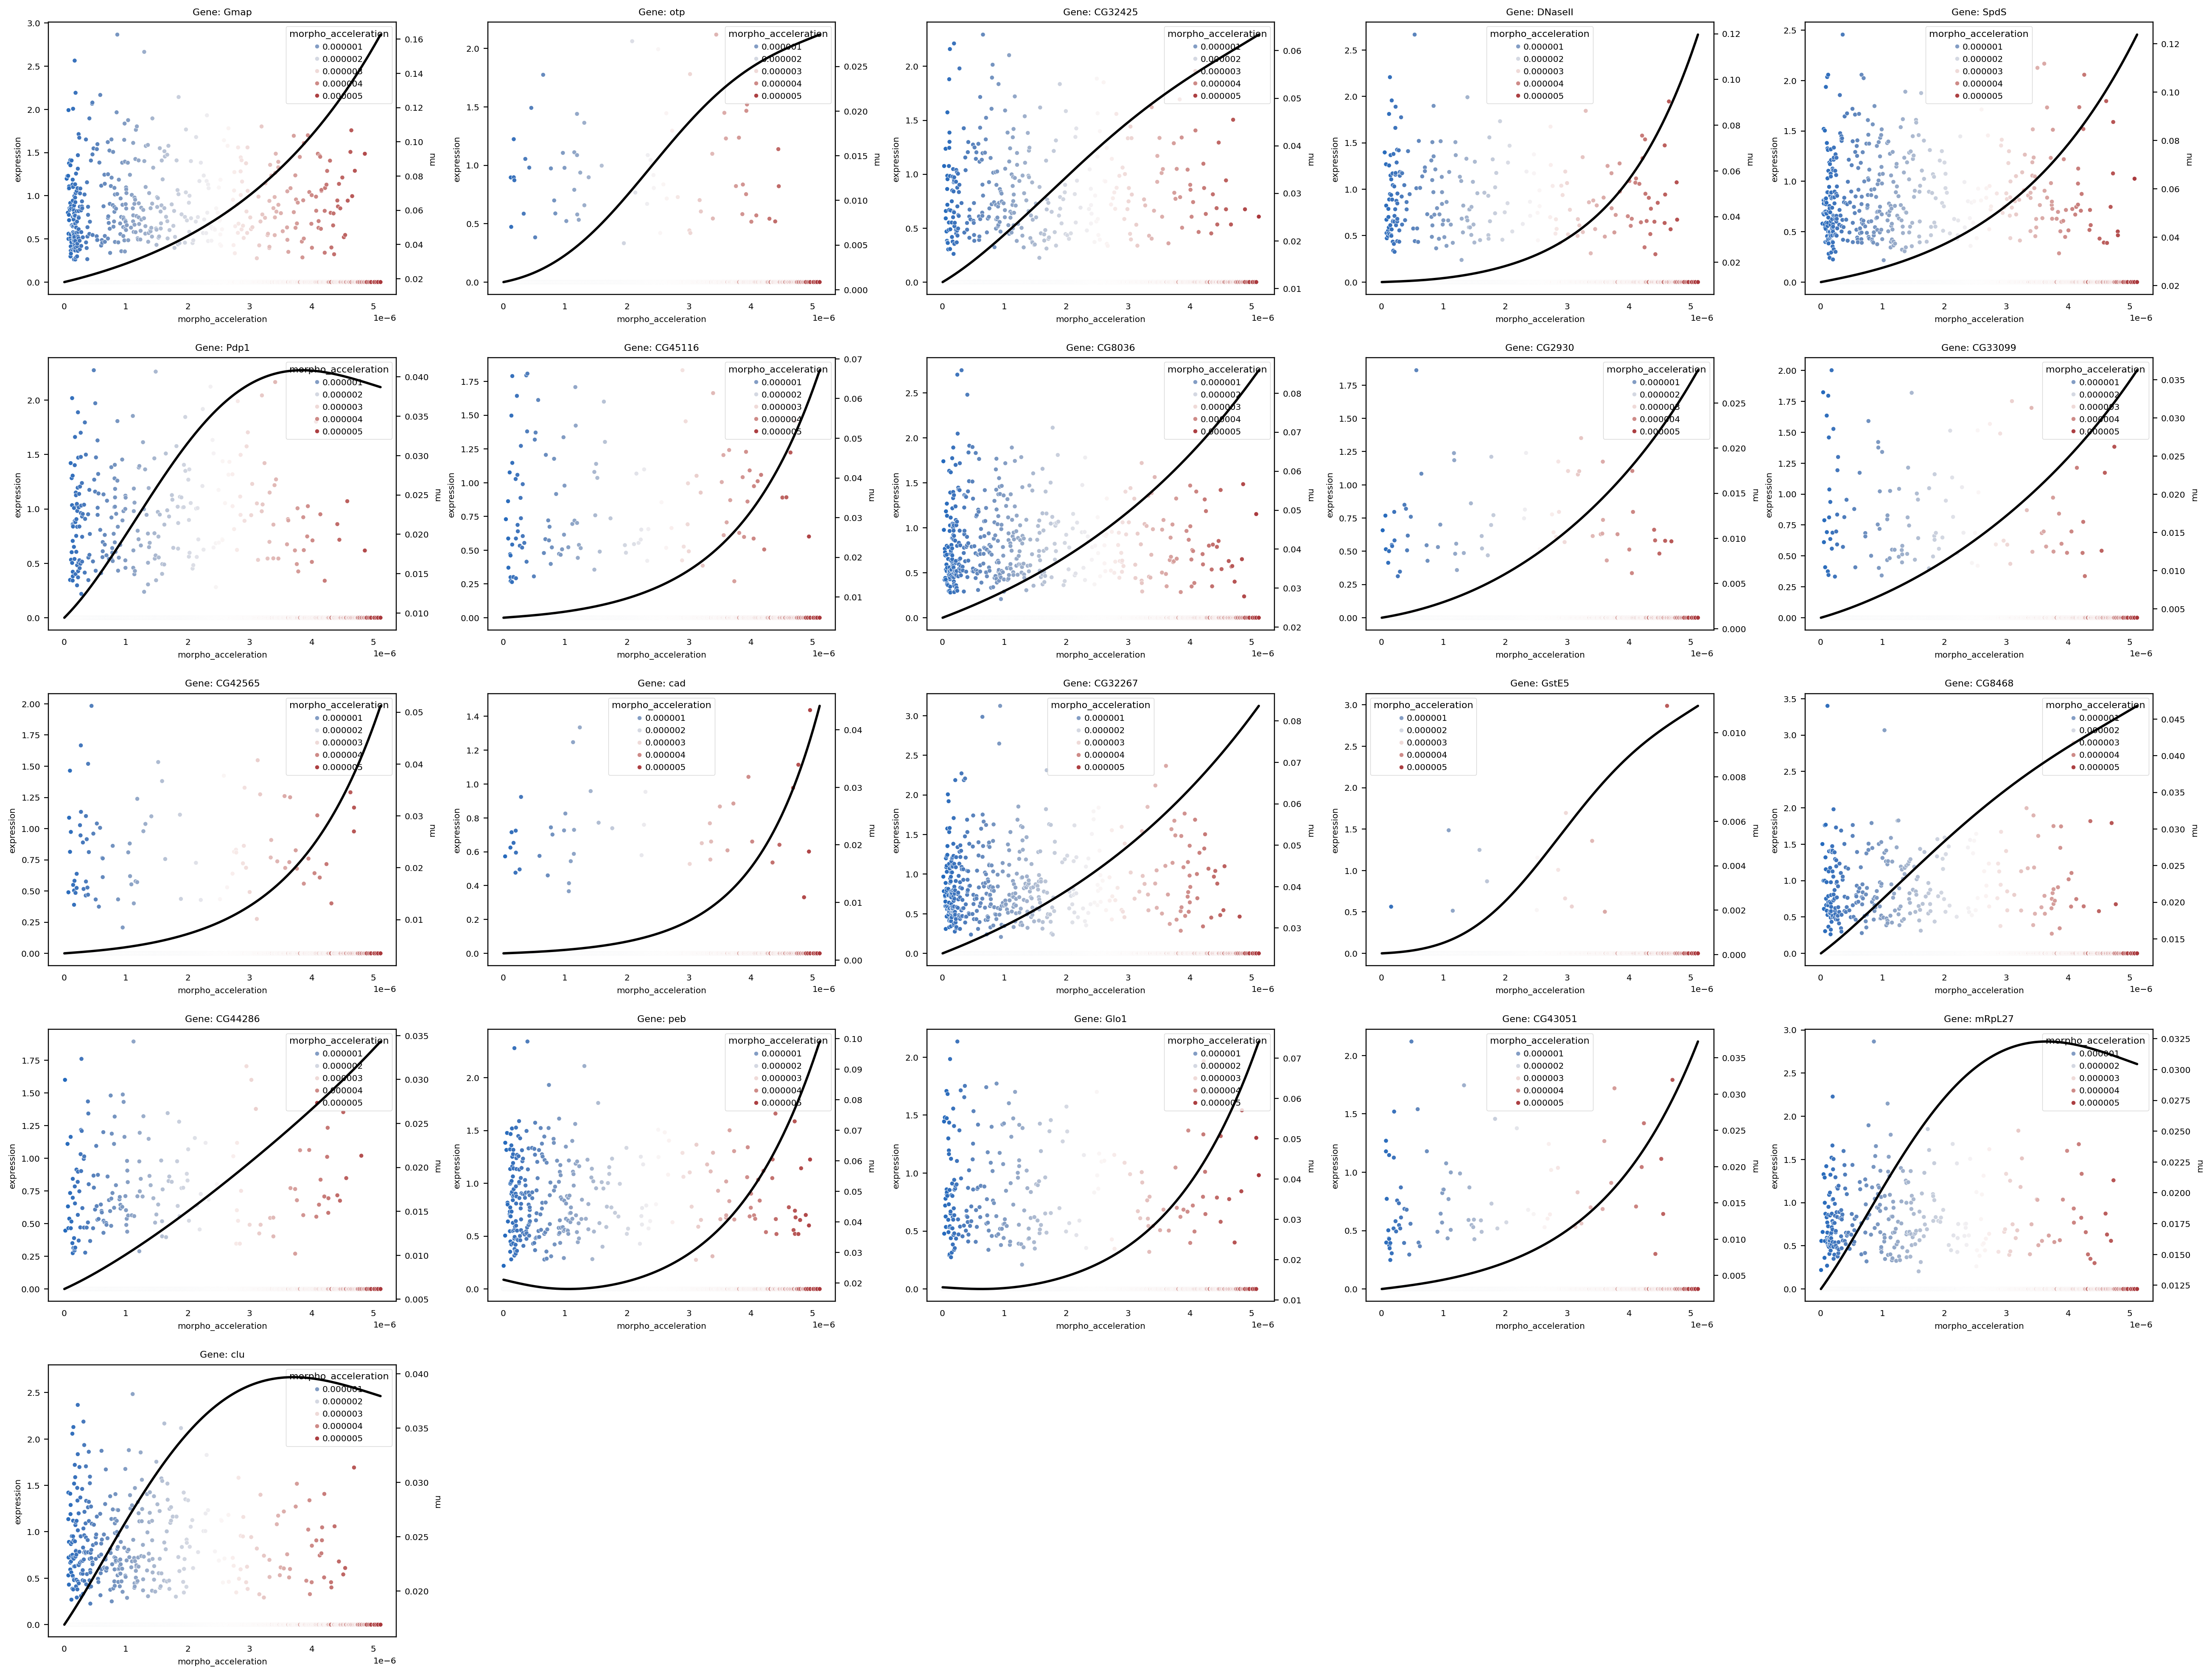

(<Figure size 3000x2000 with 42 Axes>,
 [<Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes: xlabel='morpho_acceleration', ylabel='mu'>,
  <Axes

In [12]:
selected_genes = ["Gmap", "otp","CG32425","DNaseII","SpdS","Pdp1","CG45116","CG8036","CG2930","CG33099",
                  "CG42565","cad","CG32267","GstE5","CG8468","CG44286","peb","Glo1","CG43051","mRpL27","clu",]
st.pl.glm_fit(
    adata=germ_adata,
    genes=selected_genes,
    ncols=5,
    feature_x="morpho_acceleration",
    feature_y="expression",
    glm_key="glm_degs",
    save_show_or_return="all",
    color_key="morpho_acceleration",
    color_key_cmap="vlag",
    save_kwargs=dict(path=os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_selected_glm_degs_fit"),
                     prefix=None, ext="pdf", dpi=100)
)

In [18]:
for gn in selected_genes:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    out_image_genes = os.path.join(out_image_path, "acceleration_genes")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)
    
    pc_index=germ_pc.point_data["obs_index"].tolist()
    exp = germ_adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=germ_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="afmhot_r")
    
    st.pl.three_d_plot(
        model=germ_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_genes, f"{sample_id}_germband_morpho_acceleration_model_{_gn}.pdf")
    )

In [19]:
for gn in selected_genes:
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    out_image_genes = os.path.join(out_image_path, "acceleration_genes_colorbar")
    Path(out_image_genes).mkdir(parents=True, exist_ok=True)
    
    pc_index=germ_pc.point_data["obs_index"].tolist()
    exp = germ_adata[pc_index, gn].X.A.flatten()
    st.tdr.add_model_labels(model=germ_pc, labels=exp, key_added=gn, where="point_data",inplace=True, colormap="afmhot_r")

    st.pl.three_d_plot(
        model=germ_pc,
        key=gn,
        model_style="points",
        model_size=14,
        opacity=0.4,
        colormap="afmhot_r",
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_genes, f"{sample_id}_germband_morpho_acceleration_model_{_gn}_with_colorbar.pdf")
    )

## GO term

In [5]:
import gseapy as gp
gp.get_library_name(organism="fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [7]:
 # GO-biologial process
go_folder = os.path.join(out_image_path, f"{sample_id}_morpho_acceleration_GO_all")
Path(go_folder).mkdir(parents=True, exist_ok=True)

selected_genes = list(germ_adata.uns["glm_degs"]["glm_result"].index)
go_bp = gp.enrichr(
        gene_list=selected_genes,
        gene_sets="GO_Biological_Process_GeneRIF",
        organism="fly",
        outdir=go_folder,
        no_plot=True,
        verbose=True
)

2023-09-18 22:34:50,796 [INFO] Run: GO_Biological_Process_GeneRIF 
2023-09-18 22:34:57,113 [INFO] Save enrichment results for GO_Biological_Process_GeneRIF 
2023-09-18 22:34:57,114 [INFO] Done.


In [30]:
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.fly.enrichr.reports.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_acceleration_go_bp_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2023', cmap='viridis_r', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{sample_id}_morpho_acceleration_go_bp_selected_dotplot.pdf"))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


## Checking genes

In [13]:
completed_data = []
for gn in selected_genes:
    data = germ_adata.uns["glm_degs"]["correlation"][gn]
    data = data[["morpho_acceleration", "expression"]]
    data = data[data["expression"] != 0]
    data["backbone_nodes"] = germ_adata.obs.loc[data.index, "backbone_nodes"]
    data["GNs"] = gn
    
    # data.sort_values(by="morpho_acceleration", ascending=True, axis=0, inplace=True)
    completed_data.append(data)

completed_data = pd.concat(completed_data, axis=0)
completed_data

,morpho_acceleration,expression,backbone_nodes,GNs
338-E8-10_b_S06-E8-10_b_S06-E8-10_b_S06-E8-10_b_S06,1.190877e-06,0.507023,44,Gmap
779-E8-10_b_S07-E8-10_b_S07-E8-10_b_S07-E8-10_b_S07,2.762144e-06,0.333866,47,Gmap
197-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08,9.601979e-07,0.533244,34,Gmap
714-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10,1.234863e-06,0.493087,44,Gmap
1197-E8-10_b_S11-E8-10_b_S11-E8-10_b_S11-E8-10_b_S11,5.297966e-07,0.530747,32,Gmap
...,...,...,...,...
1038-E8-10_b_S25-E8-10_b_S25-E8-10_b_S25-E8-10_b_S25,3.591070e-07,1.333732,4,clu
713-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17,3.028146e-07,0.547867,8,clu
921-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20,7.150141e-08,0.530747,6,clu
673-E8-10_b_S21-E8-10_b_S21-E8-10_b_S21-E8-10_b_S21,1.369025e-07,0.752633,7,clu


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

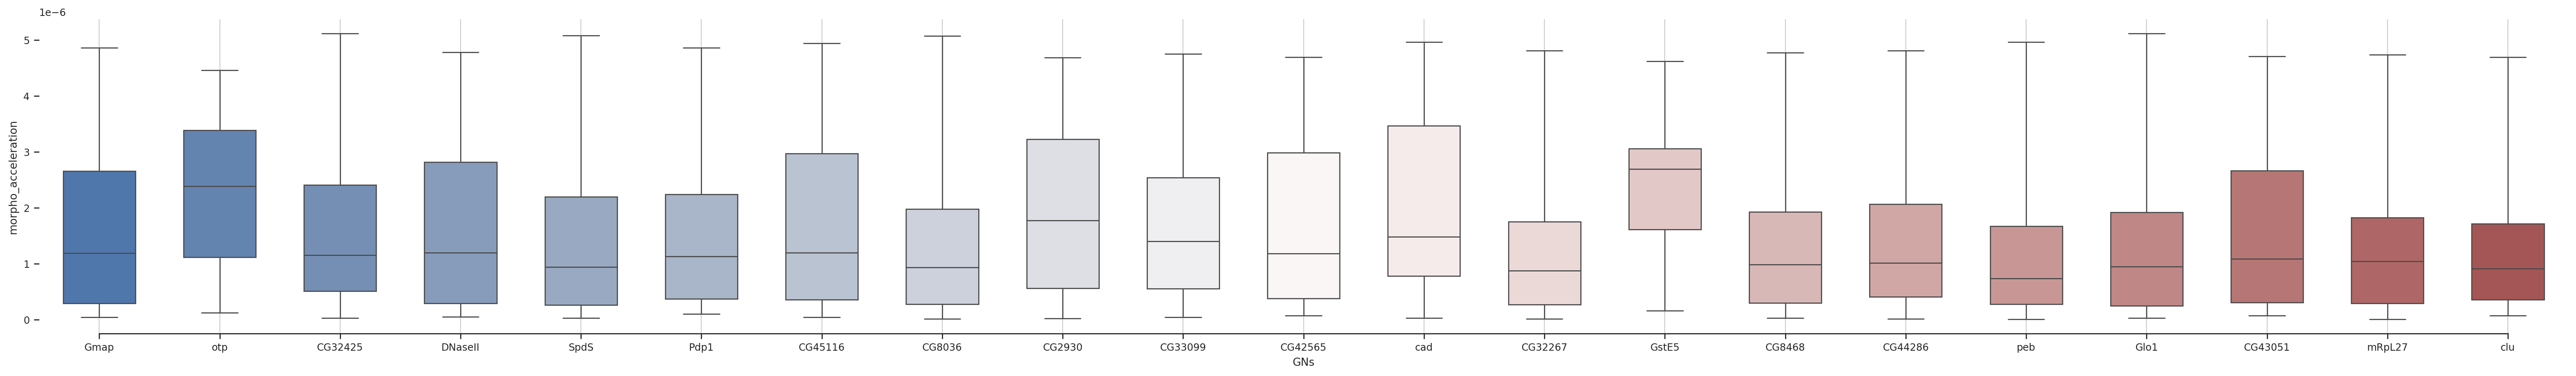

In [14]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(40, 5))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="GNs", y="morpho_acceleration", data=completed_data, whis=[0, 100], width=.6, palette="vlag")

# Tweak the visual presentation
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_boxplot.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

In [15]:
completed_mean_data = []
for gn in glm_data.index:
    data = germ_adata.uns["glm_degs"]["correlation"][gn]
    data = data[["morpho_acceleration", "expression"]]
    data = data[data["expression"] != 0]
    data["backbone_nodes"] = germ_adata.obs.loc[data.index, "backbone_nodes"]
    mean_data = data.mean(axis = 0)
    mean_data["GNs"] = gn
    completed_mean_data.append(mean_data)

completed_mean_data = pd.concat(completed_mean_data, axis=1).T
completed_mean_data.sort_values(by="backbone_nodes", ascending=False, axis=0, inplace=True)
completed_mean_data.index = range(len(completed_mean_data.index))
print(completed_mean_data)

   morpho_acceleration expression backbone_nodes          GNs
0             0.000002   1.081442      42.857143        GstE5
1             0.000002    0.86391      42.252747        Abd-B
2             0.000002   1.008506       41.62963  lncRNA:iab8
3             0.000002   0.952262      40.544118          otp
4             0.000002   0.930798      38.927835        Acbp5
..                 ...        ...            ...          ...
83                 0.0   0.872667            8.8  PH4alphaSG1
84                 0.0     0.7436       8.076923        Optix
85                 0.0   0.802905       7.545455          toy
86                 0.0   0.826731       6.047619       TfAP-2
87                 0.0   0.900289       4.761905           gt

[88 rows x 4 columns]


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

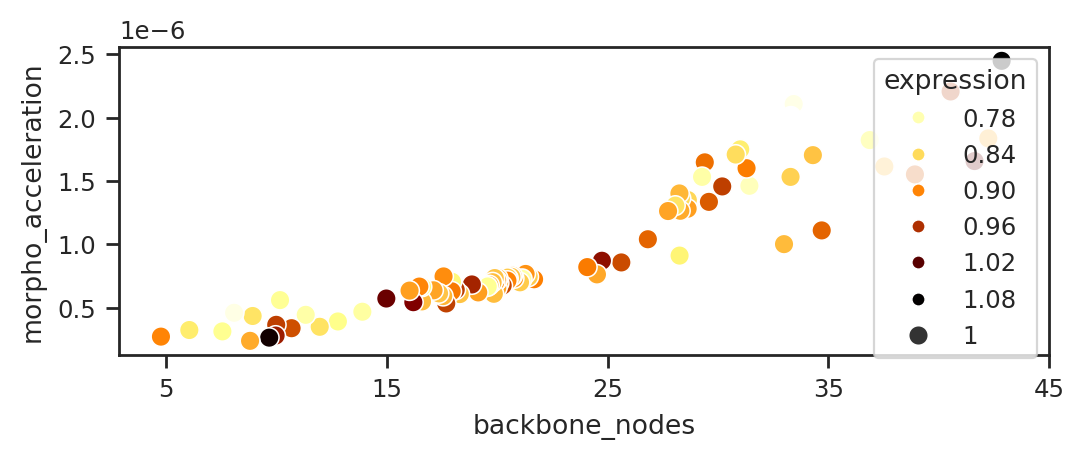

In [16]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(6, 2))
sns.scatterplot(x="backbone_nodes", y="morpho_acceleration", data=completed_mean_data, hue="expression", palette="afmhot_r", size=1, sizes=(50, 100), ax=ax)
ax.set_xticks([5, 15, 25, 35, 45])
#scatter = ax.scatter(x=completed_mean_data["morpho_acceleration"], y=completed_mean_data["backbone_nodes"], c=completed_mean_data["expression"], vmin=0.6, vmax=1.1, cmap="afmhot_r")
#legend1 = ax.legend(*scatter.legend_elements(num=5), loc="upper left", title="Ranking")
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_mean_points.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

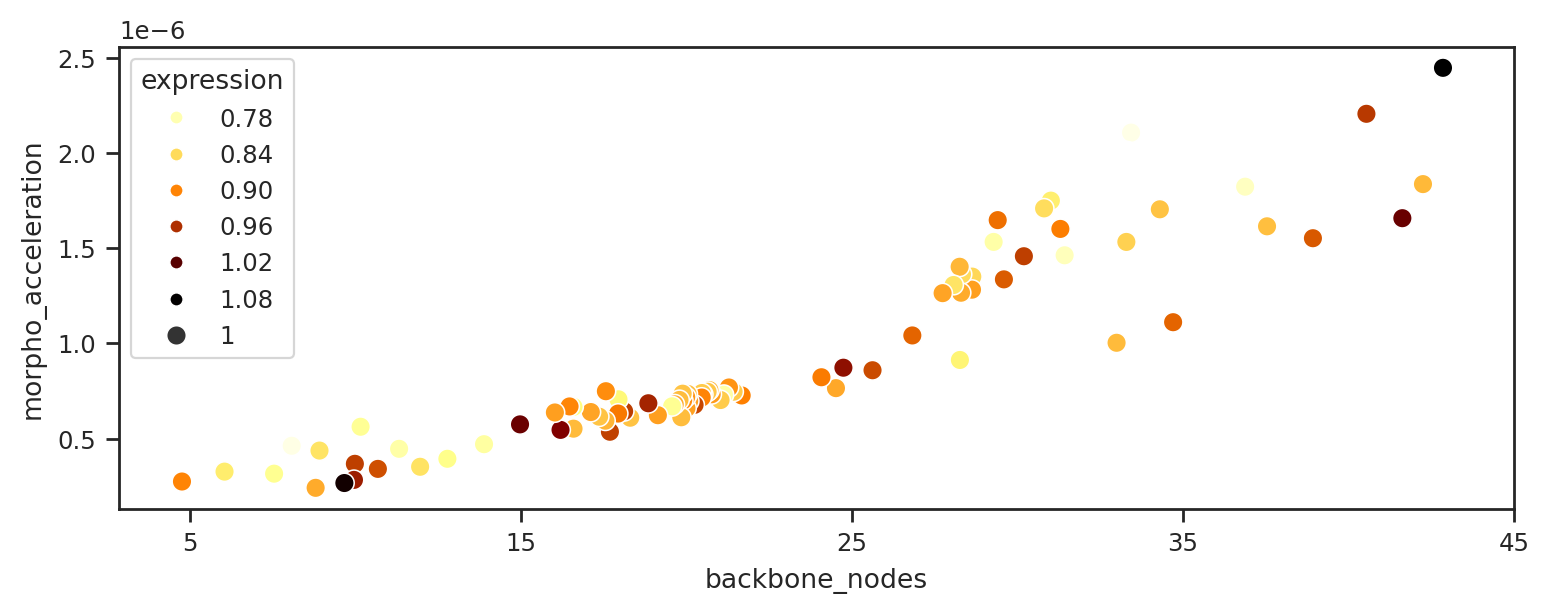

In [17]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(9, 3))
sns.scatterplot(x="backbone_nodes", y="morpho_acceleration", data=completed_mean_data, hue="expression", palette="afmhot_r", size=1, sizes=(50, 100), ax=ax)
ax.set_xticks([5, 15, 25, 35, 45])
#scatter = ax.scatter(x=completed_mean_data["morpho_acceleration"], y=completed_mean_data["backbone_nodes"], c=completed_mean_data["expression"], vmin=0.6, vmax=1.1, cmap="afmhot_r")
#legend1 = ax.legend(*scatter.legend_elements(num=5), loc="upper left", title="Ranking")
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_mean_points_2.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

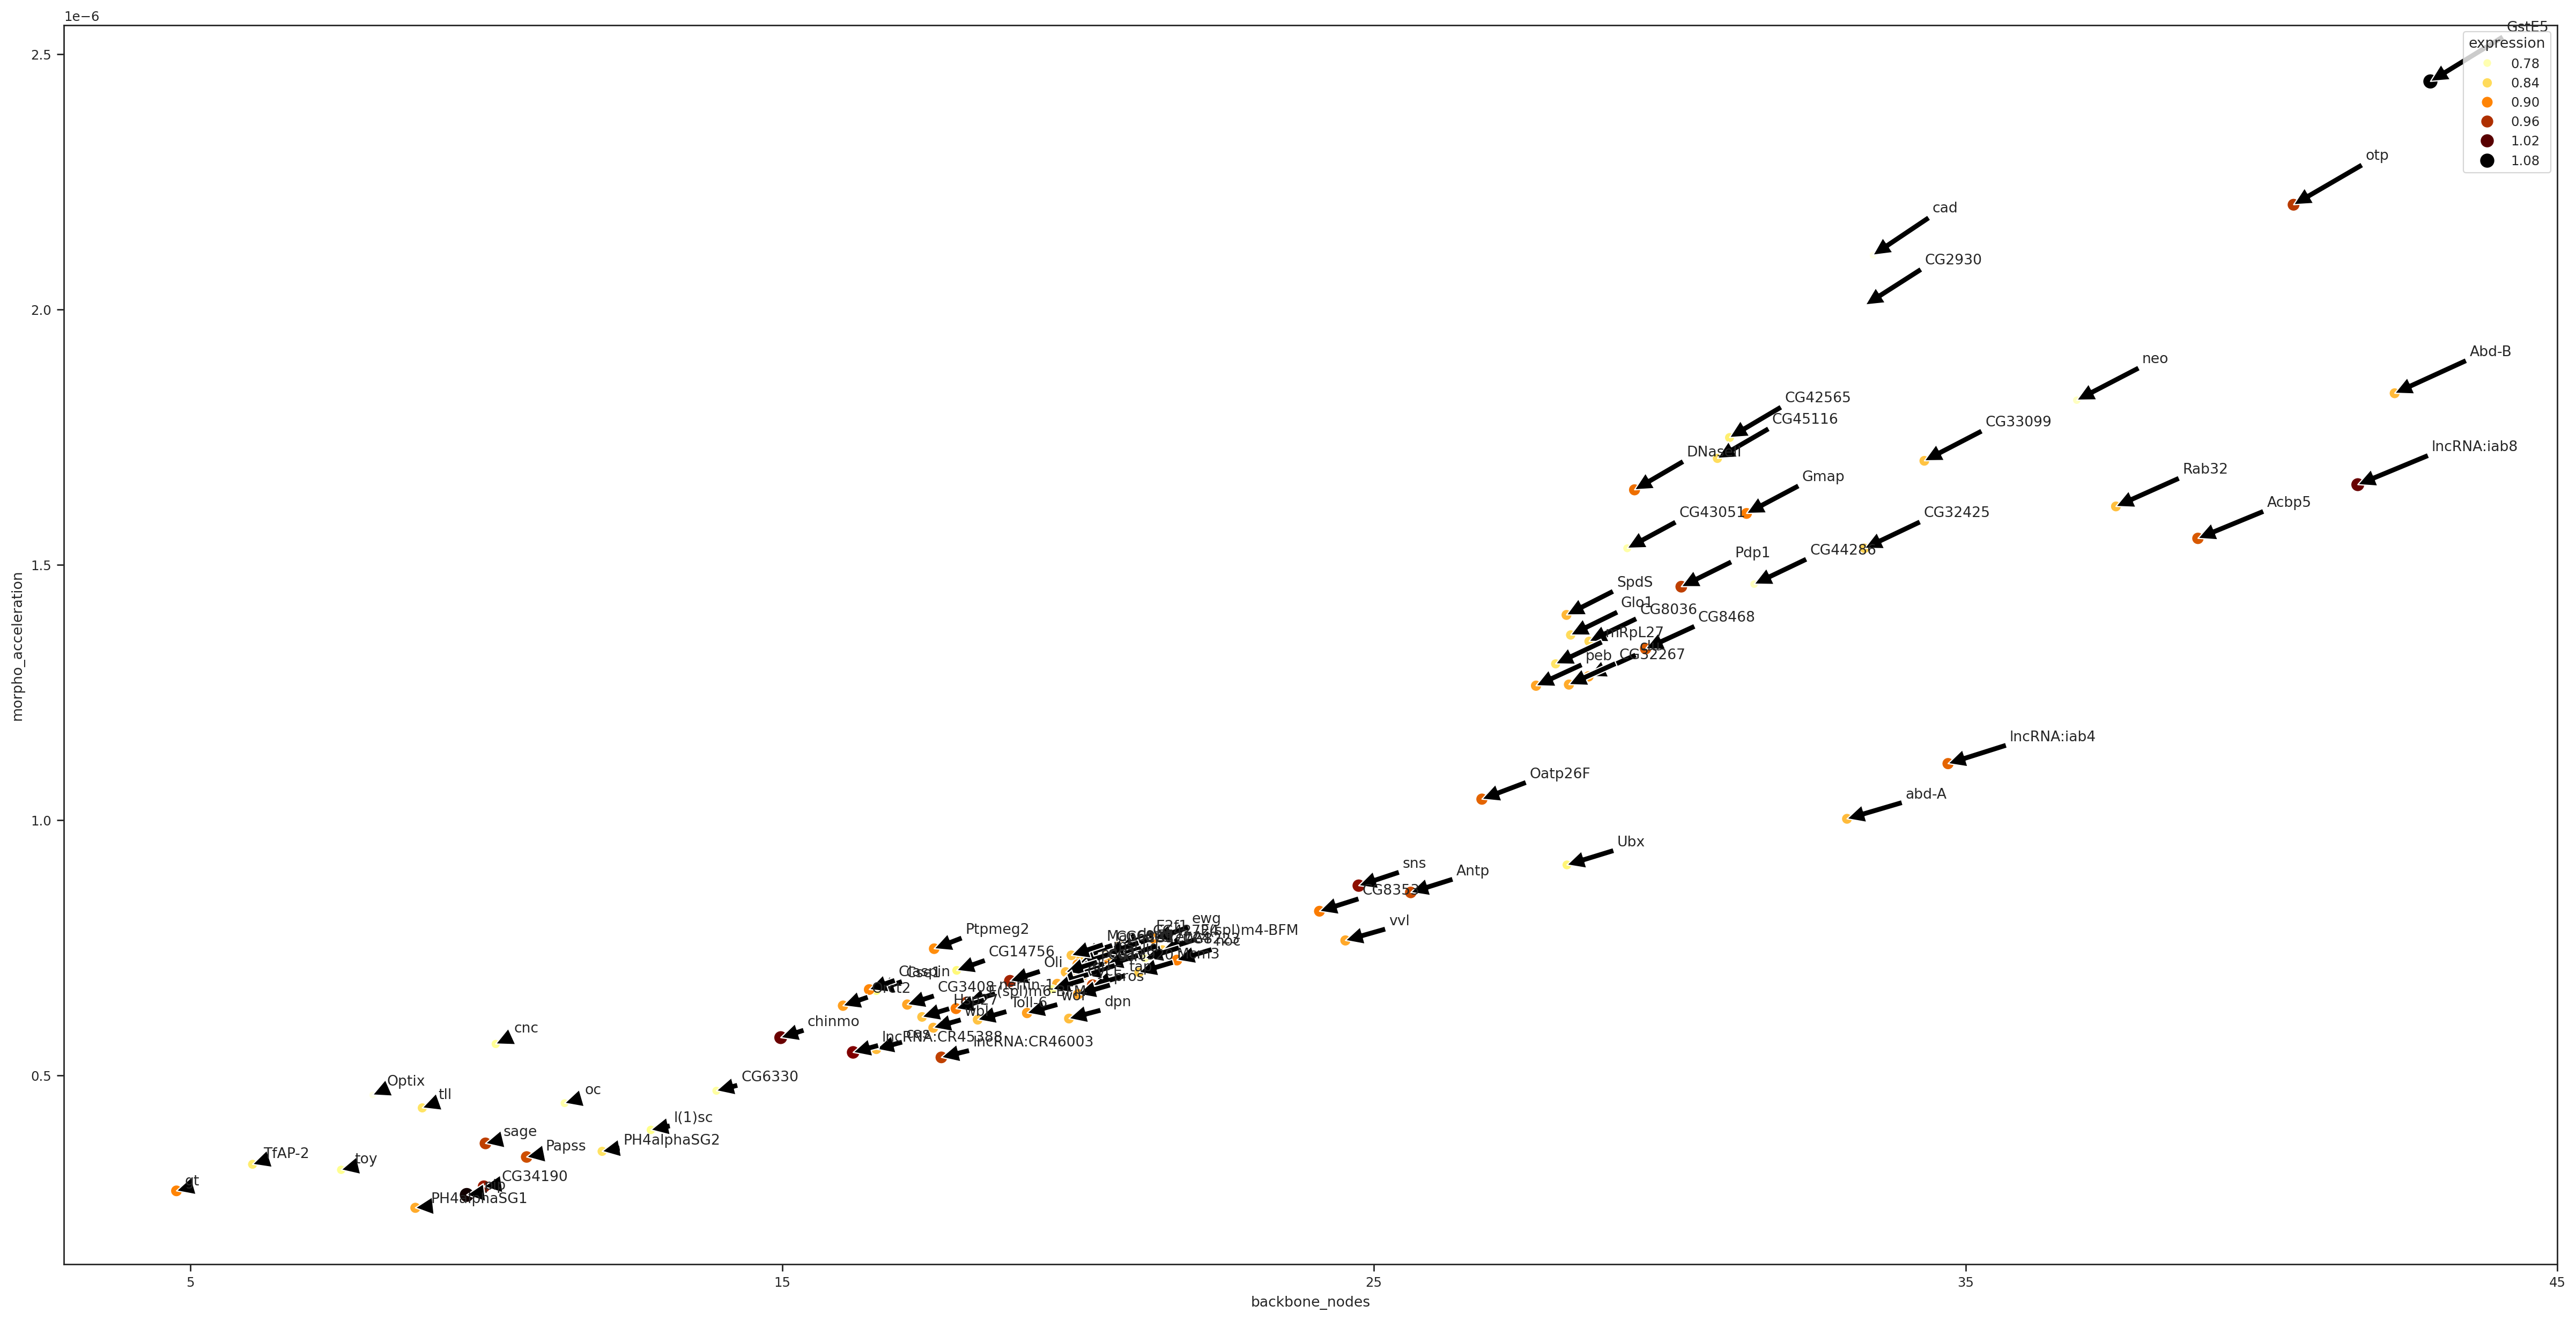

In [18]:
sns.set_theme(context="paper", style="ticks", font="Arial")
f, ax = plt.subplots(figsize=(30, 15))
sns.scatterplot(x="backbone_nodes", y="morpho_acceleration", data=completed_mean_data, hue="expression", size="expression", palette="afmhot_r", sizes=(20, 100), ax=ax)
ax.set_xticks([5, 15, 25, 35, 45])
acceleration_genes = [
    "Gmap", "otp","CG32425","DNaseII","SpdS","Pdp1","CG45116","CG8036","CG2930","CG33099",
    "CG42565","cad","CG32267","GstE5","CG8468","CG44286","peb","Glo1","CG43051","mRpL27","clu",
]
for i in range(len(completed_mean_data)):
    data = completed_mean_data.iloc[i, :]
    ax.annotate(data["GNs"], xy=(data["backbone_nodes"], data["morpho_acceleration"]), xytext=(data["backbone_nodes"] * 1.03, data["morpho_acceleration"] * 1.04),
                arrowprops=dict(facecolor='black', shrink=0.001))
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germband_morpho_acceleration_glm_degs_mean_points_with_labels.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

In [30]:
st.pl.three_d_plot(
        model=germ_pc,
        key="morpho_curl",
        model_style="points",
        model_size=14,
        opacity=1,
        colormap="afmhot_r",
        show_legend=True,
        jupyter=False,
        cpo=cpo,
        window_size=(2560, 2048),
    )

([(-31.389489056849133, 822.0672881528578, -104.29118272311966),
  (13.0, 8.0, -3.0),
  (0.028036860857194913, 0.12493073213775896, 0.9917692506832414)],
 pyvista_ndarray([[[255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255],
                   ...,
                   [255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255]],
 
                  [[255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255],
                   ...,
                   [255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255]],
 
                  [[255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255],
                   ...,
                   [255, 255, 255],
                   [255, 255, 255],
                   [255, 255, 255]],
 
                  ...,
 
                  [[255, 255, 255],
                   [255, 255, 255],
                   [

## Save curl_related anndata object

In [31]:
germ_adata

AnnData object with n_obs × n_vars = 12585 × 8120
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion'
    uns: 'VecFld_morpho', 'glm_degs', 'log1p', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

In [32]:
germ_adata.write_h5ad(f"h5ad/{sample_id}_germband_v4_acceleration.h5ad", compression="gzip")

In [4]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_germband_v4_acceleration.h5ad")

In [5]:
glm_data = germ_adata.uns["glm_degs"]["glm_result"]
selected_genes = ["Gmap", "otp","CG32425","DNaseII","SpdS","Pdp1","CG45116","CG8036","CG2930","CG33099",
                  "CG42565","cad","CG32267","GstE5","CG8468","CG44286","peb","Glo1","CG43051","mRpL27","clu",]
glm_data = glm_data.loc[selected_genes, :]
glm_data.to_csv(os.path.join(out_image_path, f"Germband_acceleration_selected_glm_degs.csv"), sep="\t")
glm_data

,status,family,log-likelihood,pval,qval
Gmap,ok,NB2,-1748.306274,1.720348e-26,1.074556e-23
otp,ok,NB2,-371.687927,1.078223e-15,3.287929e-13
CG32425,ok,NB2,-1289.530151,2.322101e-14,6.285153e-12
DNaseII,ok,NB2,-1012.456604,6.221524e-14,1.530872e-11
SpdS,ok,NB2,-1682.759888,2.165884e-13,5.172640e-11
Pdp1,ok,NB2,-1173.230347,3.570789e-12,7.630212e-10
CG45116,ok,NB2,-561.447144,6.564757e-10,9.691968e-08
CG8036,ok,NB2,-1709.352173,1.872589e-08,1.974730e-06
CG2930,ok,NB2,-292.684692,1.721330e-08,1.839106e-06
CG33099,ok,NB2,-547.889465,7.069992e-08,6.753921e-06
